In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

# Yeni eklenen kütüphaneler:
import skimage.morphology as morp
from sklearn.utils import shuffle
from skimage.filters import rank

#np.random.seed(30)
import random
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Load data & Labels 

In [2]:
data=np.load('./saved/data.npy')
labels=np.load('./saved/target.npy')

In [3]:
X_train, X_valid, y_train, y_valid = train_test_split(data, labels, test_size=0.2, random_state=0)

## Data Preprocessing

Bu adımda, mümkün olan en iyi sonuçları elde etmek için giriş görüntülerine birkaç ön işleme adımı uygulayacağız. Aşağıdaki ön işleme tekniklerini kullanacağız:\
Shuffling\
Grayscaling\
Local Histogram Equalization\
Normalization

Shuffling(Karıştırma): Genel olarak, modelin daha kararlı olması için eğitim veri setindeki rastgeleliği ve çeşitliliği artırmak için eğitim verilerini karıştırırız. Verilerimizi karıştırmak için sklearn kullanacağız.

In [4]:
X_train, y_train = shuffle(X_train, y_train)

GrayScaling(Gri Tonlama) : Gri tonlamalı görüntüler, bazı görüntü işleme ve analiz teknikleri için daha uygun olabilir. Örneğin, kenar tespiti, görüntü segmentasyonu ve nesne tanıma gibi işlemler, gri tonlamalı görüntülerde daha iyi sonuçlar verebilir. Renk bilgisine ihtiyaç duyulmadığı durumlarda, gri tonlamalı görüntülerin kullanılması verimlilik sağlayabilir. Ayrıca bellek kullanımı ve hesaplama maliyetini azaltır. P. Sermanet ve Y. LeCun, 2011 yılında yayınlanan "Traffic Sign Recognition with Multi-Scale Convolutional Networks" adlı makalelerinde, renk yerine gri tonlamalı görüntülerin kullanılmasının CNN'in doğruluğunu artırdığını belirtmişlerdir. Eğitim görüntülerini gri tonlamaya dönüştürmek için OpenCV kullanacağız.

In [5]:
def gray_scale(image): # image np.array objesi olmalı
    # görüntüyü gri tonlamalı hale dönüştür:
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

In [6]:
gray_images = list(map(gray_scale, X_train))

Gray Scaled Traffic Sign Images


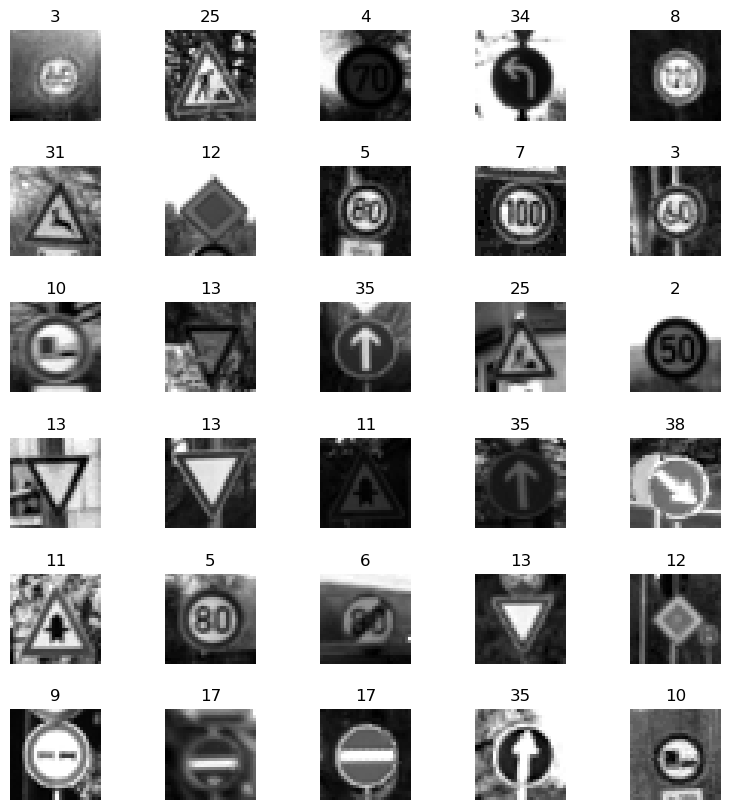

In [7]:
print("Gray Scaled Traffic Sign Images")
fig, axs = plt.subplots(6, 5, figsize=(10, 10))  # 6 satır 5 sütunluk bir grid oluşturur
fig.subplots_adjust(hspace=0.5, wspace=0.001)
axs = axs.ravel()
for i in range(30):
    index = random.randint(0, len(X_train))
    image = gray_images[index] 
    axs[i].axis('off')
    axs[i].imshow(image, cmap='gray')  # cmap='gray' parametresi ile gri tonlama renk haritası kullanır
    axs[i].set_title(y_train[index])

plt.show()

Local Histogram Equalization (Yerel Histogram Eşitleme): Bu teknik, bir görüntüde en sık görülen yoğunluk değerlerini yayarak, düşük kontrasta sahip görüntüleri iyileştirmeyi sağlar. Bu teknik, elimizdeki veri setinin gerçek dünya görüntülerini içerdiği ve bunların birçoğunun düşük kontrasta sahip olduğu durumlarda çok faydalı olacaktır. Eğitim görüntülerine yerel histogram eşitleme uygulamak için scikit-image(skimage) kütüphanesini kullanacağız.

In [8]:
def local_histo_equalize(image): # image gri tonlamalı olmalı
    # gri tonlamalı görüntüye yerel histogram eşitleme uygula:
    kernel = morp.disk(30)
    img_local = rank.equalize(image, selem=kernel)
    return img_local

In [9]:
equalized_images = list(map(local_histo_equalize, gray_images))

Equalized Traffic Sign Images


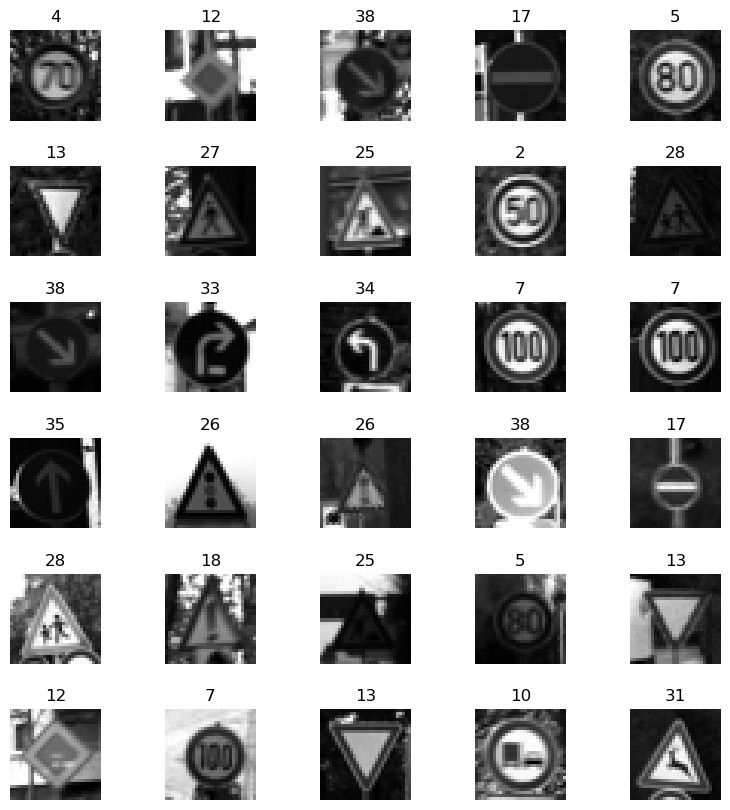

In [10]:
print("Equalized Traffic Sign Images")
fig, axs = plt.subplots(6, 5, figsize=(10, 10))  # 6 satır 5 sütunluk bir grid oluşturur
fig.subplots_adjust(hspace=0.5, wspace=0.001)
axs = axs.ravel()
for i in range(30):
    index = random.randint(0, len(X_train))
    image = gray_images[index] 
    axs[i].axis('off')
    axs[i].imshow(image, cmap='gray')  # cmap='gray' parametresi ile gri tonlama renk haritası kullanır
    axs[i].set_title(y_train[index])

plt.show()

Normalization(Normalleştirme): Görüntü verilerindeki piksel yoğunluk değerlerinin aralığını değiştiren bir işlemdir. Bu işlem, verilerin ortalama sıfır ve eşit varyansa sahip olacak şekilde dönüştürülmesini sağlar. Bu sayede, görüntü verileri daha tutarlı ve karşılaştırılabilir hale gelir.

In [11]:
def image_normalize(image):
    #Görüntüleri [0,1] ölçeğine normalleştirme
    image = np.divide(image, 255) 
    return image

In [12]:
# Normalizasyon işleminden sonra örnek görüntüler:
n_training = X_train.shape
normalized_images = np.zeros((n_training[0], n_training[1], n_training[2]))
for i, img in enumerate(equalized_images):
    normalized_images[i] = image_normalize(img)

Normalized Traffic Sign Images


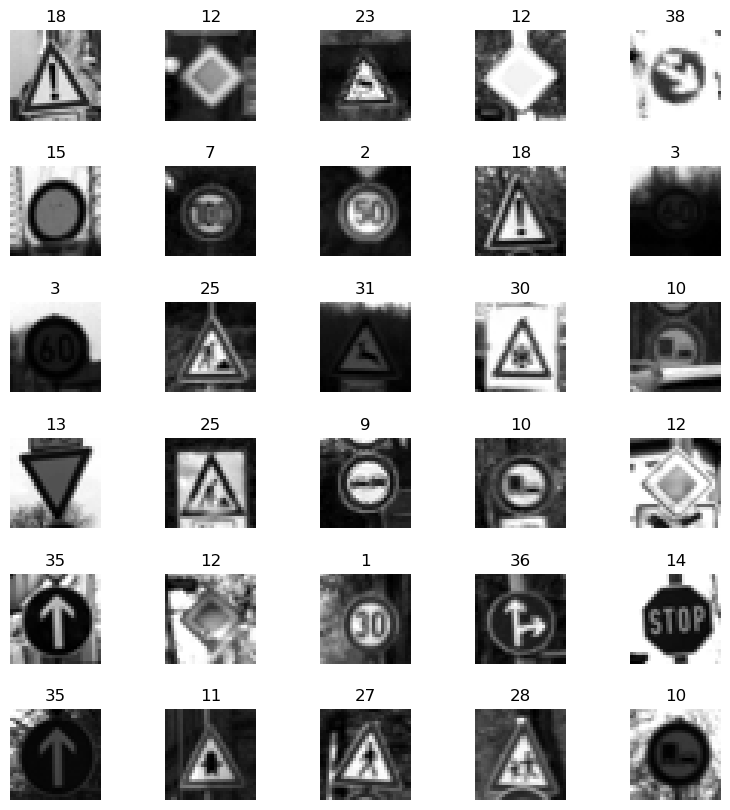

In [13]:
print("Normalized Traffic Sign Images")
fig, axs = plt.subplots(6, 5, figsize=(10, 10))  # 6 satır 5 sütunluk bir grid oluşturur
fig.subplots_adjust(hspace=0.5, wspace=0.001)
axs = axs.ravel()
for i in range(30):
    index = random.randint(0, len(X_train))
    image = gray_images[index] 
    axs[i].axis('off')
    axs[i].imshow(image, cmap='gray')  # cmap='gray' parametresi ile gri tonlama renk haritası kullanır
    axs[i].set_title(y_train[index])

plt.show()

In [14]:
normalized_images = normalized_images[..., None]

In [15]:
# Veriye ön işleme adımlarını uygular:
def preprocess(data):
    gray_images = list(map(gray_scale, data))
    equalized_images = list(map(local_histo_equalize, gray_images))
    n_training = data.shape
    normalized_images = np.zeros((n_training[0], n_training[1], n_training[2]))
    for i, img in enumerate(equalized_images):
        normalized_images[i] = image_normalize(img)
    normalized_images = normalized_images[..., None]
    return normalized_images

In [16]:
X_train_preprocessed = preprocess(X_train)
X_val_preprocessed = preprocess(X_valid)

One Hot Encoding

In [17]:
y_train = to_categorical(y_train, 43)
y_valid = to_categorical(y_valid, 43)

## Build the Model

Ön işleme tabii tutulmuş olan verilerin model performansına etkisinin gözlenebilmesi için aynı model oluşturulmuştur:

In [18]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train_preprocessed.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
# 43 sınıfımız olduğu için son katman bu sınıf sayısıyla eşleşmeli:
model.add(Dense(43, activation='softmax'))
#Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
epochs = 25
history = model.fit(X_train_preprocessed, y_train, batch_size=32, epochs=epochs, validation_data=(X_val_preprocessed, y_valid))

Epoch 1/25
981/981 [==============================] - 61s 59ms/step - loss: 1.2020 - accuracy: 0.6615 - val_loss: 0.1577 - val_accuracy: 0.9584
Epoch 2/25
981/981 [==============================] - 64s 65ms/step - loss: 0.2644 - accuracy: 0.9188 - val_loss: 0.0993 - val_accuracy: 0.9731
Epoch 3/25
981/981 [==============================] - 54s 55ms/step - loss: 0.1640 - accuracy: 0.9502 - val_loss: 0.0813 - val_accuracy: 0.9770
Epoch 4/25
981/981 [==============================] - 55s 56ms/step - loss: 0.1388 - accuracy: 0.9582 - val_loss: 0.0697 - val_accuracy: 0.9830
Epoch 5/25
981/981 [==============================] - 54s 55ms/step - loss: 0.1108 - accuracy: 0.9657 - val_loss: 0.0479 - val_accuracy: 0.9880
Epoch 6/25
981/981 [==============================] - 55s 56ms/step - loss: 0.0955 - accuracy: 0.9693 - val_loss: 0.0501 - val_accuracy: 0.9879
Epoch 7/25
981/981 [==============================] - 54s 55ms/step - loss: 0.0935 - accuracy: 0.9716 - val_loss: 0.0456 - val_accuracy:

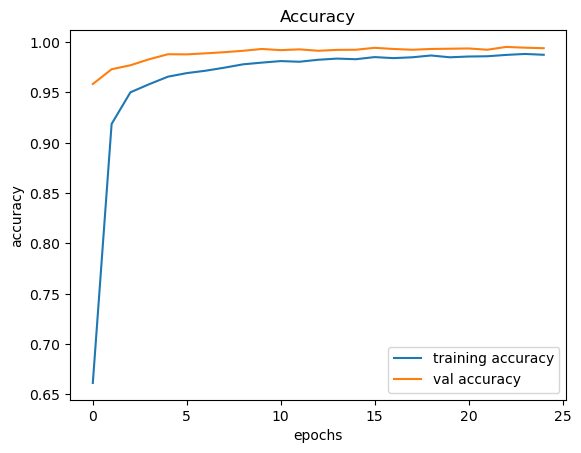

In [19]:
# accuracy 
import matplotlib.pyplot as plt
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

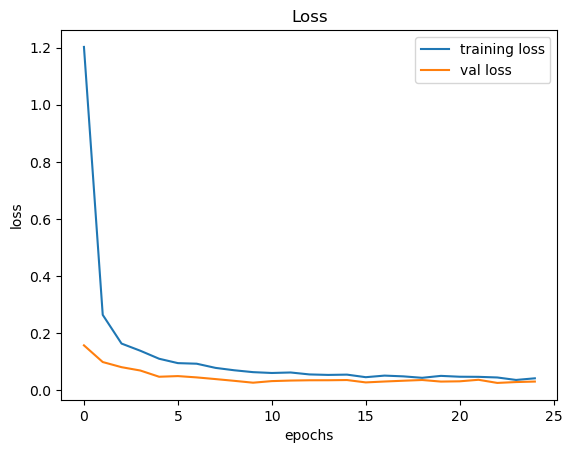

In [20]:
# Loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

### Testing on Test Data 

In [21]:
os.getcwd()

'C:\\Users\\LENOVO\\Desktop\\Proje2'

In [22]:
def testing(testcsv):
    y_test = pd.read_csv(testcsv) # Test.csv dosyası okunur
    label = y_test["ClassId"].values # Test.csv dosyasındaki ClassId sütunu yani etiketler numpy arrayine dönüştürülür
    imgs = y_test["Path"].values # Test.csv dosyasındaki Path sütunu imgs numpy arrayine dönüştürülür
    data=[]
    for img in imgs:
        img = img.lstrip("Test/")
        image_path = os.path.join(os.getcwd(),"archive","Test")
        image = Image.open(image_path + "\\" + img)
        image = image.resize((30,30))
        data.append(np.array(image))
    X_test=np.array(data)
    return X_test,label # Yeniden boyutlandırılmış ve numpy arrayine dönüştürülmüş görseller ve sınıfları geri döndürülür

In [23]:
X_test, label = testing('archive/Test.csv')

Test verisi üzerinde uygulamamız gereken işlemler, modeli eğittiğimiz veri ön işleme adımlarıyla tutarlı olmalıdır. Bu nedenle, test verisine de aynı işlemleri uyguluyorum:

In [24]:
X_test_preprocessed = preprocess(X_test)

In [25]:
# model.predict_classes(X_test)
Y_pred = model.predict(X_test_preprocessed)
y_pred_classes = np.argmax(Y_pred, axis=1)
print(y_pred_classes)

395/395 [==============================] - 5s 11ms/step
[16  1 38 ... 15  7 10]


### Confusion Matrix

In [26]:
# Confusion Matrix Oluşturulması:
from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(label, y_pred_classes) # y_true, y_pred
print(cm)

[[ 55   0   0 ...   0   0   0]
 [  0 708   1 ...   0   0   0]
 [  0   3 745 ...   0   0   0]
 ...
 [  0   0   0 ...  80   0   3]
 [  0   0   0 ...   0  57   0]
 [  0   0   0 ...   0   0  89]]


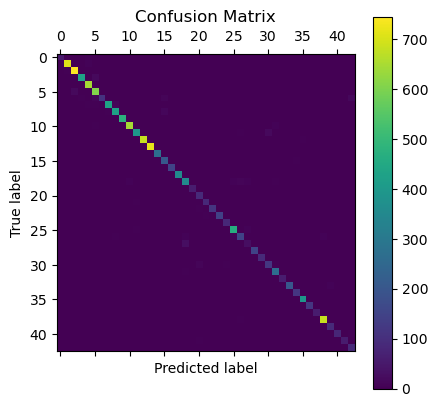

In [27]:
# Confusion matrix gösterimi
plt.matshow(cm)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Classification Report

In [28]:
from sklearn.metrics import classification_report
cr = classification_report(label, y_pred_classes) # y_true, y_pred
print(cr)

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        60
           1       0.98      0.98      0.98       720
           2       0.97      0.99      0.98       750
           3       0.98      0.95      0.96       450
           4       0.97      0.98      0.97       660
           5       0.93      0.96      0.94       630
           6       1.00      0.73      0.84       150
           7       0.99      0.96      0.97       450
           8       0.96      0.95      0.95       450
           9       0.99      1.00      1.00       480
          10       0.99      0.98      0.98       660
          11       0.98      0.94      0.96       420
          12       0.99      0.99      0.99       690
          13       0.99      1.00      0.99       720
          14       1.00      0.99      0.99       270
          15       0.89      0.97      0.93       210
          16       0.99      0.99      0.99       150
          17       1.00    

In [29]:
from sklearn.metrics import accuracy_score
print(accuracy_score(label, y_pred_classes))

0.965716547901821


## Testing with External Images

In [30]:
# Trafik işaretleri sınıfları
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In [31]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
def test_on_img(img):
    data=[]
    image = Image.open(img)
    image = image.resize((30,30))
    data.append(np.array(image))
    X_test=np.array(data)
    X_test = preprocess(X_test)
    Y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(Y_pred, axis=1)
    return image,y_pred_classes

1/1 [==============================] - 0s 41ms/step
Predicted traffic sign is:  Turn right ahead


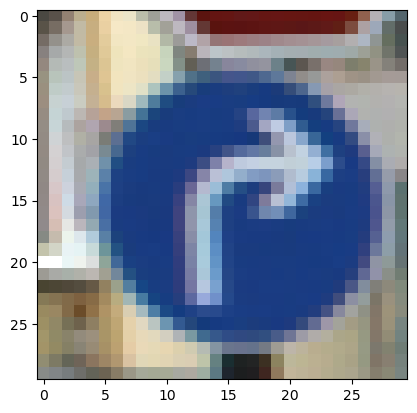

In [32]:
plot,prediction = test_on_img(r'C:\Users\LENOVO\Desktop\Proje2\external\t1.png')
s = [str(i) for i in prediction] 
a = int("".join(s)) 
print("Predicted traffic sign is: ", classes[a])
plt.imshow(plot)
plt.show()

1/1 [==============================] - 0s 28ms/step
Predicted traffic sign is:  Stop


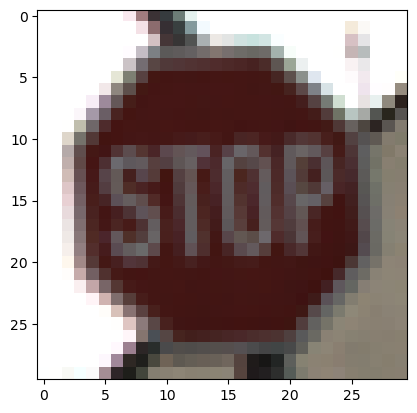

In [33]:
plot,prediction = test_on_img(r'C:\Users\LENOVO\Desktop\Proje2\external\t2.png')
s = [str(i) for i in prediction] 
a = int("".join(s)) 
print("Predicted traffic sign is: ", classes[a])
plt.imshow(plot)
plt.show()

1/1 [==============================] - 0s 37ms/step
Predicted traffic sign is:  Road work


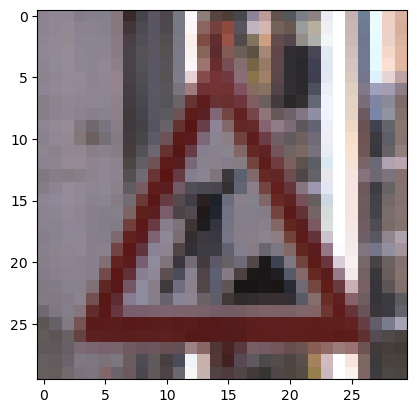

In [34]:
plot,prediction = test_on_img(r'C:\Users\LENOVO\Desktop\Proje2\external\t3.png')
s = [str(i) for i in prediction] 
a = int("".join(s)) 
print("Predicted traffic sign is: ", classes[a])
plt.imshow(plot)
plt.show()